In [1]:
# Create a L layer neural network to classify MNIST dataset
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataset import Subset
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from MNIST_diffusion import MNIST_Model
import numpy as np

In [8]:


class MNISTClassifier(nn.Module):
    def __init__(self,  hidden1, hidden2,inputsize = 28*28):
        super(MNISTClassifier, self).__init__()
        self.input_size = inputsize
        self.hidden1 = hidden1
        self.hidden2 = hidden2
        # self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f'Using {self.device}')
        # Define the layers of the neural network
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(self.input_size, self.hidden1).to(self.device))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Linear(self.hidden1, self.hidden2).to(self.device))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Linear(self.hidden2, 10).to(self.device))
        self.layers.append(nn.LogSoftmax(dim=1))

        # define input transformations
        self.transform = transforms.Compose([transforms.Normalize((0.5,), (0.5,))])
        self.diff_transform = transforms.Compose([transforms.Resize(28), transforms.Normalize((0.5,), (0.5,))])

        # Load the diffusion model
        self.diffusionModel = MNIST_Model(pathtoModel=r"steps_00046900.pt")
        self.diffusionModel.Model.to(self.device)

    
    def forward(self, x):
        # apply transformations to the input
        for layer in self.layers:
            x = layer(x)
        return x
    
    def classify_image(self, img):
        with torch.no_grad():
            output = self.forward(img)
        return output.argmax(dim=1).item()
    
    
    def optimize_image(self, layer, neuron_index, steps=200, lr=0.1, input_image=None, printEpochs=True, diff_lr = 0.1):
        '''
        params:
        layer: the layer to optimize the neuron for
        neuron_index: the index of the neuron to optimize
        steps: the number of steps to optimize the image
        lr: the learning rate
        input_image: the initial image to optimize, if None, a random image is generated
        printEpochs: whether to print the progress of the optimization
        diff_lr: the ratio of the diffusion model to the activation of the neuron
        '''
        if input_image is None:
            input_image = torch.randn((1,1,28,28), requires_grad=True, device=self.device)
        else:
            input_image = input_image.clone().detach().requires_grad_().to(self.device)
        
        optimizer = optim.NAdam([input_image], lr=lr)
        neuron_loss_list = []
        diff_loss_list = []
        total_loss_list = []
        image_list = [input_image.clone().detach()]
        for step in range(steps):
            optimizer.zero_grad()
            # Calculate the loss for the neuron
            self.get_activations(self.transform(input_image).view(1, -1))
            activation_layer = self.activations[layer][0]
            activation_layer = (activation_layer - activation_layer.mean()) / activation_layer.std()
            neuron_loss = -activation_layer[neuron_index].pow(2)

            # Calculate the loss for the diffusion model
            t0 = (1 - step / steps)
            diff_loss = self.diffusionModel.get_score(self.diff_transform(input_image.requires_grad_(True)).requires_grad_(True),  t0) # score is naturally negative

            # combine the two losses
            loss = neuron_loss + diff_lr * diff_loss

            # calculate the diffusion addition every 2 steps
            if step % 2 == 0:
                noise= torch.randn_like(input_image).to(self.device)
                t = int(t0 * (self.diffusionModel.timesteps-1))
                t=torch.tensor([t for _ in range(1)]).to(self.device)
                updated_image = self.diffusionModel.Model._reverse_diffusion(input_image,t,noise)

                input_image = (1-diff_lr) * input_image + diff_lr * updated_image 
            
            else:
                input_image = input_image

            # backpropagate the loss
            loss.backward(retain_graph=True)
            optimizer.step()
            
            # update the lists
            neuron_loss_list.append(neuron_loss.item())
            diff_loss_list.append(diff_loss.item())
            total_loss_list.append(loss.item())

            # print the progress
            if step % (steps // 10) == 0 and printEpochs:
                image_list.append(input_image.clone().detach())
                avg_neuron_loss = np.mean(neuron_loss_list)
                avg_diff_loss = np.mean(diff_loss_list)
                print(f'Step {step+1}, Loss: {loss.item()}, Neuron Loss: {avg_neuron_loss}, Diff Loss: {avg_diff_loss}', end='\r')

        image_list.append(input_image.clone().detach())
        
        return (input_image, (neuron_loss_list, diff_loss_list, total_loss_list, image_list))
    
    def optimize_non_standard(self, layer, neuron_index, steps=200, lr=0.1, input_image=None, printEpochs=True):
        '''
        This function is used to optimize the image to maximize the activation of a neuron in a layer
        params:
        layer: the layer to optimize the neuron for
        neuron_index: the index of the neuron to optimize
        steps: the number of steps to optimize the image
        lr: the learning rate
        input_image: the initial image to optimize, if None, a random image is generated
        printEpochs: whether to print the progress of the optimization
        NOTE this does not include the diffusion model
        '''
        if input_image is None:
            input_image = torch.randn(1, 280*280, requires_grad=True, device=self.device)
        else:
            input_image = input_image.clone().detach().requires_grad_(True).to(self.device)

        optimizer = optim.Adam([input_image], lr=lr)

        # Get the activations of the layer
        for step in range(steps):
            optimizer.zero_grad()
            # rezise the image to 28x28
            smol_input_image = nn.functional.interpolate(input_image, size=(28, 28), mode='bilinear', align_corners=True)

            self.get_activations(smol_input_image.view(1, -1))
            activation_layer = self.activations[layer][0]
            #normalize the activations
            activation_layer = (activation_layer - activation_layer.mean()) / activation_layer.std()

            #calculate the loss as the negative of the activation of the neuron relative to the other neurons
            loss = -activation_layer[neuron_index]

            loss.backward()
            optimizer.step()
            if step % (steps // 10) == 0 and printEpochs:
                print(f'Step {step+1}, Loss: {loss.item()}', end='\r')
        
        return input_image

    def _save_image(self, tensor, path):
        plt.imshow(tensor.squeeze(0).cpu().numpy(), cmap='gray')
        plt.savefig(path)
        plt.close()
    
    def train(self, train_loader=None, epochs=10, lr=0.01):
        self.get_data()
        train_loader = train_loader if train_loader else self.train_loader

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=lr)
        for epoch in range(epochs):
            running_loss = 0.0
            for i, data in enumerate(train_loader, 0):
                inputs, labels = data
                inputs = inputs.view(inputs.size(0), -1).to(self.device)
                labels = labels.to(self.device)
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

    def validate(self, val_loader=None):
        all_labels = []
        all_predictions = []
        if not val_loader:
            _, val_loader = self.get_data()
        else:
                val_loader = val_loader
        
        with torch.no_grad():
            for data in val_loader:
                inputs, labels = data
                inputs = inputs.view(inputs.size(0), -1).to(self.device)
                labels = labels.to(self.device)
                outputs = self(inputs)
                _, predicted = torch.max(outputs.data, 1)
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
        
        accuracy = accuracy_score(all_labels, all_predictions)
        return accuracy
    
    def get_activations(self, x):
        self.activations = []
        for layer in self.layers:
            x = layer(x)
            self.activations.append(x)
        return self.activations
    
    # New method to get the data
    def get_data(self, batch_size=64):
        # transform = transforms.Compose([transforms.ToTensor(),
        #                                 transforms.Normalize((0.5,), (0.5,))])
        
        # Load the training and test datasets
        train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
        val_set = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
        
        # Create DataLoader for train and validation sets
        train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

        self.train_loader = train_loader
        self.val_loader = val_loader
        
        return train_loader, val_loader
    
def plt_loss(loss_data):
    # plot the loss data for the optimization
    neuron_loss, diff_loss, total_loss, image_list = loss_data
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    # plot the neuron loss
    axs[0].plot(neuron_loss)
    axs[0].set_title('Neuron Loss')
    axs[0].set_xlabel('Step')
    axs[0].set_ylabel('Loss')
    # plot the diffusion loss
    axs[1].plot(diff_loss)
    axs[1].set_title('Diffusion Loss')
    axs[1].set_xlabel('Step')
    axs[1].set_ylabel('Loss')
    # plot the total loss
    axs[2].plot(total_loss)
    axs[2].set_title('Total Loss')
    axs[2].set_xlabel('Step')
    axs[2].set_ylabel('Loss')
    plt.tight_layout()
    plt.show()

    # plot the images at different steps across 5 steps evenly spaced from image_list
    fig, axs = plt.subplots(1, len(image_list), figsize=(20, 10))

    for i, ax in enumerate(axs):
        ax.imshow(image_list[i].squeeze(0).squeeze(0).cpu().numpy(), cmap='gray')
        ax.axis('off')
        if i == 0:
            ax.set_title('Initial Image')
        elif i == len(image_list)-1:
            ax.set_title('Final Image')
        else:
            ax.set_title(f'Checkpoint{i}/{len(image_list)-2}')
    plt.tight_layout()
    plt.show()


In [11]:
# preprocess=transforms.Compose([transforms.Resize(28),\
#                                     transforms.ToTensor(),\
#                                     transforms.Normalize([0.5],[0.5])])
preprocess = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
# Load the MNIST dataset
mnist_train = MNIST(root='data', train=True, download=True, transform=preprocess)
mnist_test = MNIST(root='data', train=False, download=True, transform=preprocess)


# Split the training set into a training and validation set
train_indices, val_indices = train_test_split(list(range(len(mnist_train))), test_size=0.2)
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(mnist_train, batch_size=64, sampler=train_sampler)
val_loader = DataLoader(mnist_train, batch_size=64, sampler=val_sampler)
test_loader = DataLoader(mnist_test, batch_size=64)

Using cpu
Model loaded successfully
MNISTClassifier(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
)
Validation Accuracy: 0.948


Sampling: 100%|██████████| 1000/1000 [00:38<00:00, 26.19it/s]


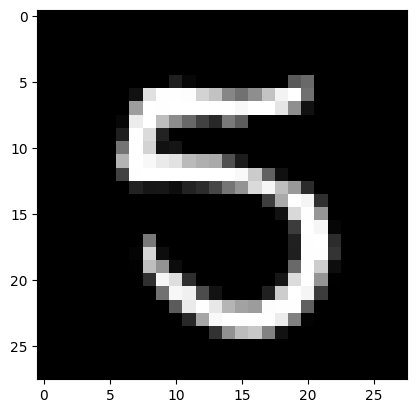

In [10]:
#print the model
model = MNISTClassifier(20, 10)
model_save = torch.load('model2.pth', map_location=torch.device(model.device), weights_only=False)
model.load_state_dict(model_save)
print(model)

# Train the model
# model.train(train_loader, epochs=5, lr=0.01)

# Validate the model
accuracy = model.validate(val_loader)
print(f'Validation Accuracy: {accuracy:.3f}')
# if accuracy > 0.90:
#     torch.save(model.state_dict(), 'model3.pth')

# sample image
sample = model.diffusionModel.Model.sampling(1)
plt.imshow(sample.squeeze(0).squeeze(0).cpu().numpy(), cmap='gray')



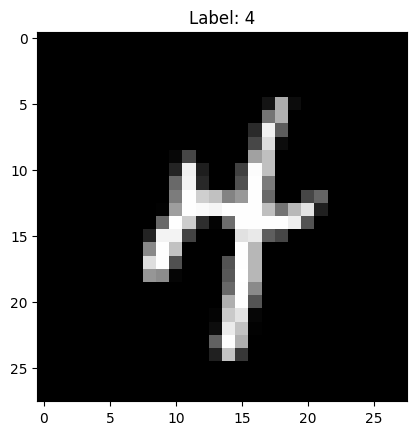

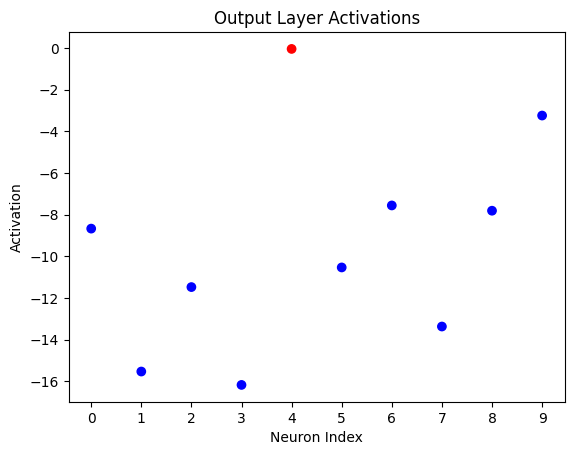

In [5]:
#show dataset data
#print activations
img, label = mnist_train[342]

#print the image
img = img.view(1, 28, 28)
plt.imshow(img.squeeze(0).numpy(), cmap='gray')
plt.title(f'Label: {label}')
plt.show()

# Get the activations of the image
img = img.view(1, -1).to(model.device)  # Move the image to the same device as the model
model.get_activations(img)

# #print the shape of the activations
# for layer in range(len(model.activations)):
#     print(f"Layer ({layer}): {model.activations[layer].shape}")

#print the last layer as a plot of activation vs layer
activations = model.activations[-1][0].cpu().detach().numpy()
colors = ['red' if i == activations.argmax() else 'blue' for i in range(len(activations))]
plt.scatter(range(10), activations, marker='o', c=colors)
plt.xticks(range(10))
plt.title('Output Layer Activations')
plt.xlabel('Neuron Index')
plt.ylabel('Activation')
plt.show()

Test diffussion Model

test x_t shape: torch.Size([1, 1, 28, 28]), device: cpu, dtype: torch.float32
Score: -1.1544078588485718


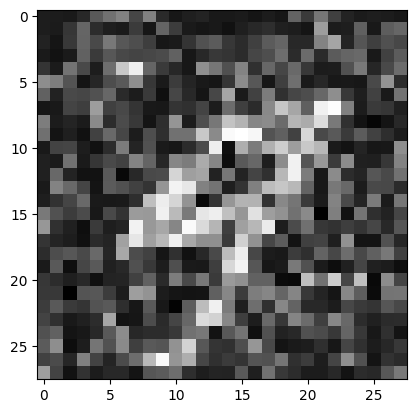

plotting the loss data


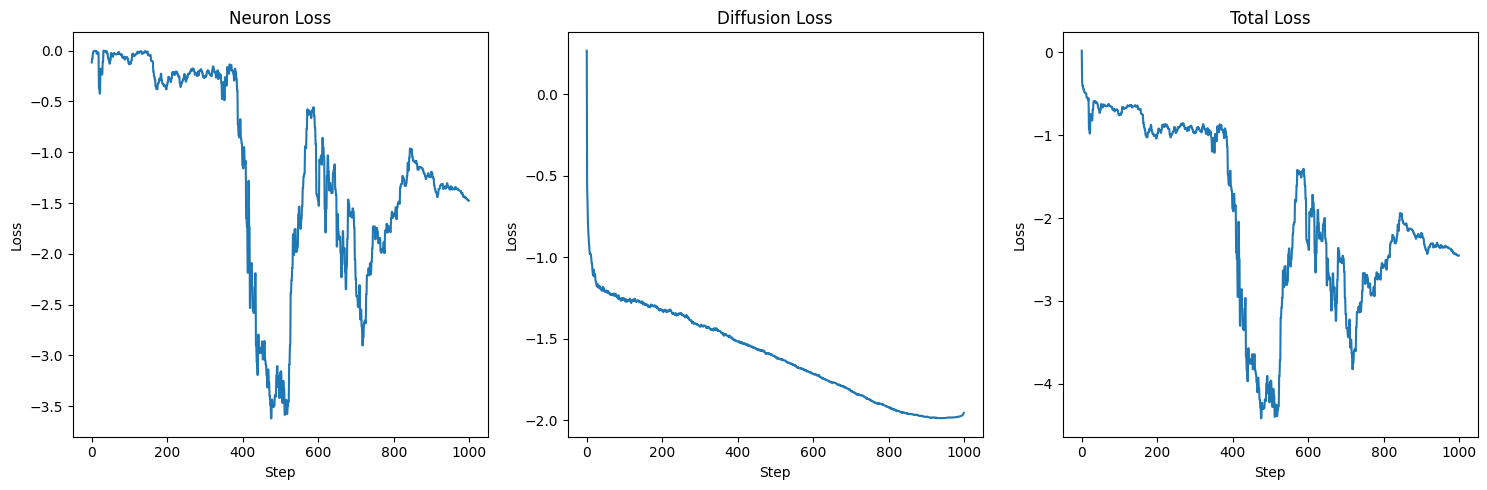

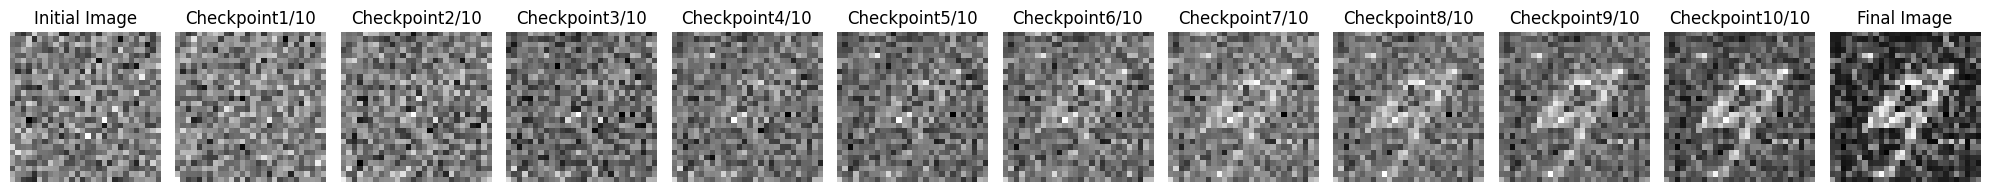

In [6]:
x_t = model.diff_transform(torch.randn((1,1,28,28))).to(model.device)
print(f"test x_t shape: {x_t.shape}, device: {x_t.device}, dtype: {x_t.dtype}")
print(f"Score: {model.diffusionModel.get_score(x_t, 0.5)}")
opt_img, loss_data = model.optimize_image(-1, 4, steps=1000, diff_lr=.5, lr=1)
plt.imshow(opt_img.squeeze(0).squeeze(0).detach().cpu().numpy(), cmap='gray')
plt.show()

print("plotting the loss data")
# Plot the loss data
plt_loss(loss_data)


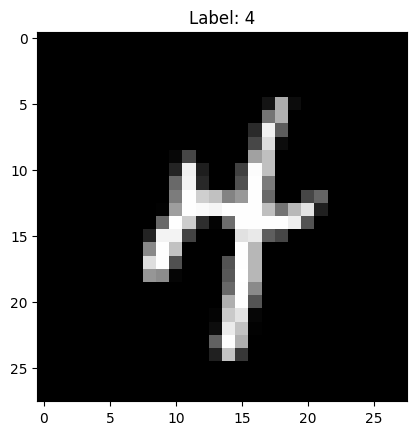

img shape: torch.Size([1, 1, 28, 28])


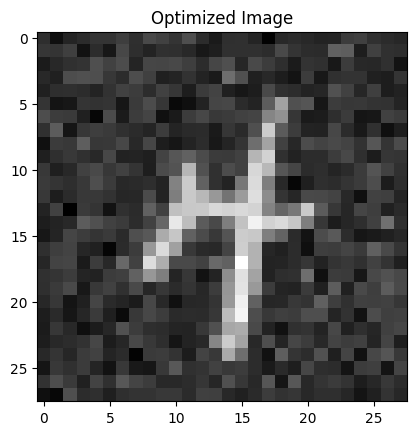

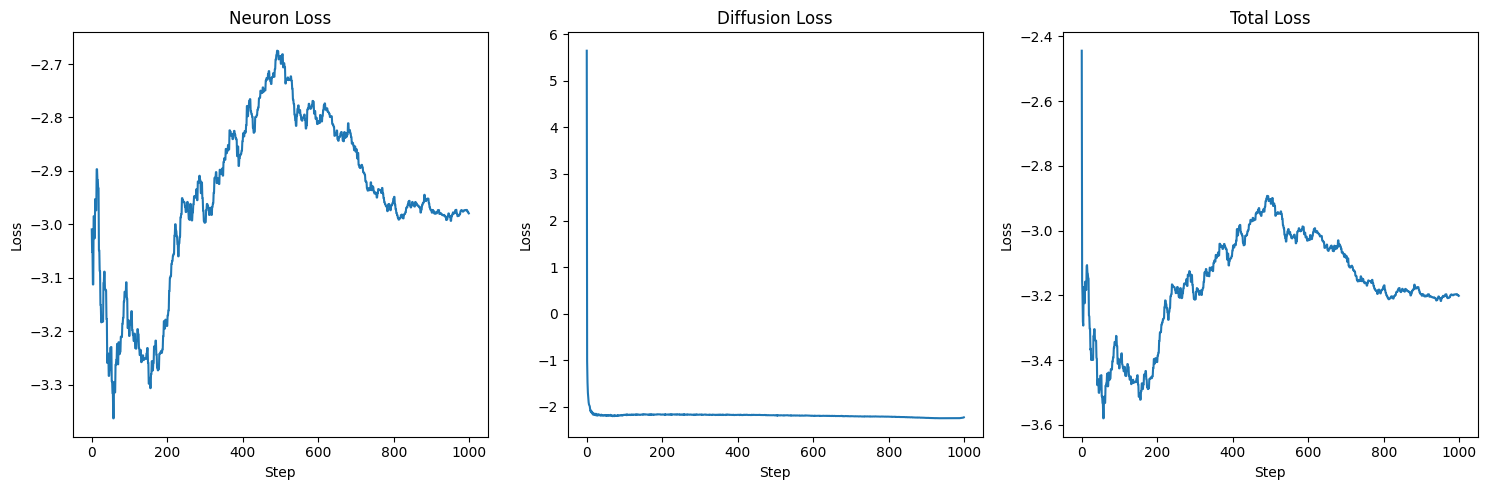

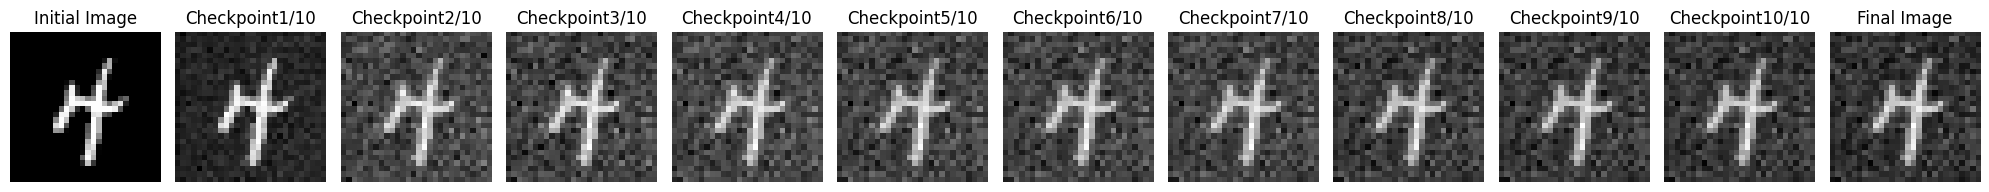

In [7]:
# start from a known image 
img, label = mnist_train[342]   
img = img.view(1, 28, 28)
img = img.clone().detach().requires_grad_(True).to(model.device)
plt.imshow(img.squeeze(0).detach().cpu().numpy(), cmap='gray')
plt.title(f'Label: {label}')
plt.show()

# Optimize the image to maximize the activation of the neuron
img = img.unsqueeze(0)
print(f"img shape: {img.shape}")
out_img, loss_data = model.optimize_image(-1, 4,input_image=img, steps=1000, diff_lr=0.1, lr=1)
plt.imshow(out_img.squeeze(0).squeeze(0).detach().cpu().numpy(), cmap='gray')
plt.title('Optimized Image')
plt.show()

# Plot the loss data
plt_loss(loss_data)